# АНАЛИЗ И ПОДГОТОВКА ИСХОДНЫХ ДАННЫХ

## 1) Импорт используемых библиотек

Сначала необходимо инпортировать все библиотеки, которые будут использоваться при обработке датасетов.

Для работы с содержимым используемого Google Диска через платформу Google Colab требуется импортировать следующие библиотеки:
- `drive` - модуль, который позволяет подключить Google Диск к виртуальной машине среды выполнения и использовать его содержимое.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Далее импортируем библиотеки, используемые непостредственно в препроцессировании данных:
- `pandas` - библиотека для обработки и анализа структурированных данных;
- `numpy` - библиотека, которую применяют для математических вычислений: начиная с базовых функций и заканчивая линейной алгеброй;
- `re` - библиотека, предоставляющая мощные инструменты для работы с текстом.
- `gensim` - библиотека обработки естественного языка предназначения для «Тематического моделирования».

In [ ]:
import numpy as np
import pandas as pd

import re
from gensim.parsing.preprocessing import preprocess_documents

## 2) Загрузка данных

В разработке будет использоваться набор датасетов, представленный Менгтингом Ван и Джулианом Маколи в научной работе «[Item Recommendation on Monotonic Behavior Chains](https://mengtingwan.github.io/paper/recsys18_mwan.pdf)» на 12-ой конференции The ACM Recommender Systems conference (RecSys).

Набор данных содержит анонимизированную информацию, полученную с интернет-портала [GoodReads](https://www.goodreads.com/) - сайта предоставляющего свободный доступ к обширной базе данных книг, аннотаций и различных обзоров. Goodreads предоставляет пользователям довольно широкий спектр возможностей. Рассмотрим некоторые из них:
- Регистрация книг, которые будут включены в общий библиотечный каталог;
- Формирование собственных книжных полок - возможность классификации книг пользователем;
- Отметка прочитанной книги;
- Постановка дифференциальной оценки (рейтинга) книге (от 0 до 5);
- Написание обзора на книгу.

Используемый набор данных включает в себя:
- Метаданные рассматриваемых книг;
- Информацию о взаимодействиях пользователей с книгами;
- Подробные обзоры книг, написанные пользователями.

Все датасеты представлены в виде `json`-файлов. Обработка файлов такого формата занимает довольно много оперативной памяти. Ввиду этого ограничения изначальный `json`-файл будет рассматриваться частями и конвертироваться в `csv`-файлы. Для этого определим фукнцию `read_json`:

In [ ]:
import gzip

def read_json(filename, nrows, skiprows=0):
    with gzip.open(filename) as f:
        for i in range(skiprows):
            next(f)
        df = pd.read_json(
            path_or_buf=f,
            lines=True,
            nrows=nrows
        )
    return df

### 2.1. Датасет метаданных рассматриваемых книг

Датасет содержит в себе метеданные книг, с которыми как-либо взаимодействовали
рассматриваемые пользователи.

Для примера приведём скриншот с сайта GoodReads, на котором содержатся метаданные книги «Дюна» Фрэнка Герберта. Представлены название серии, название книги, имя автора, рейтинг, количество оценок и обзоров, аннотация, жанры и т. д.  

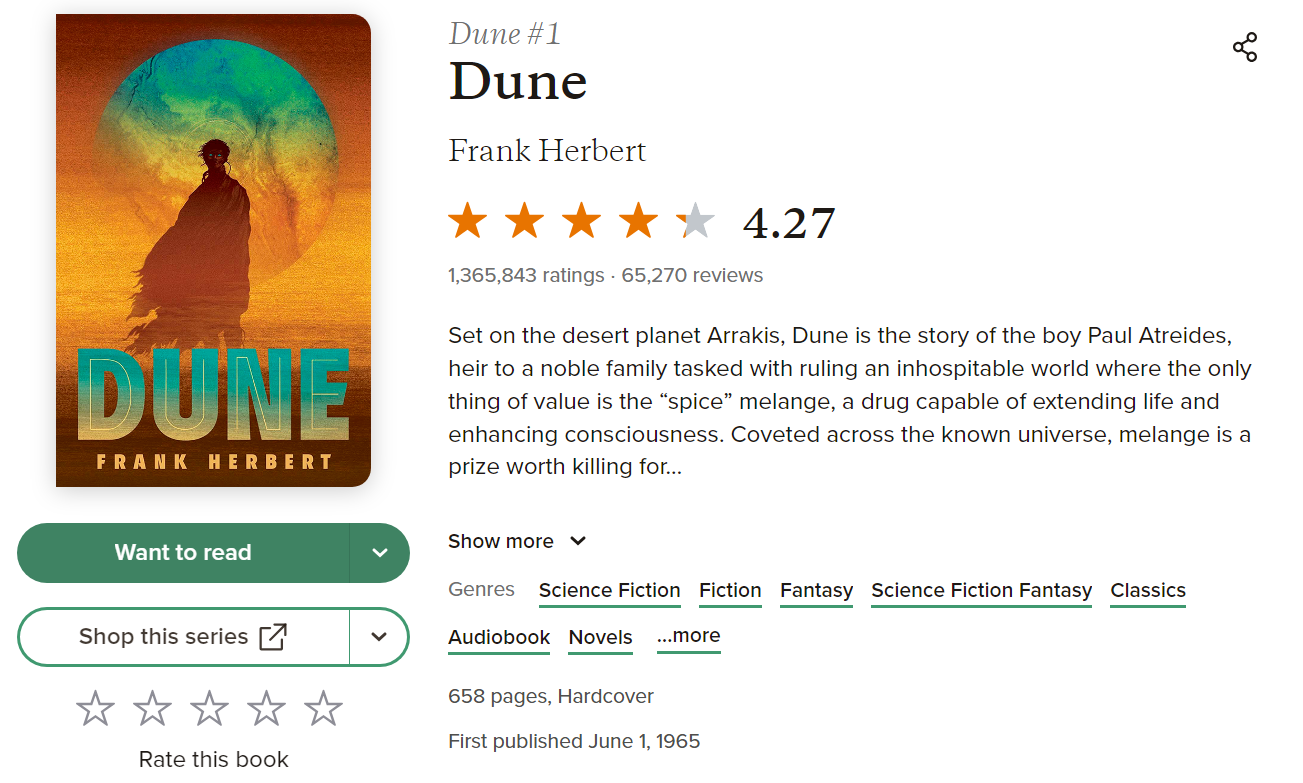

Определи функцию `create_books_subdataset`, при помощи которой будут формироваться и форматироваться части основного датасета книг:

In [ ]:
def create_books_subdataset(json_filename, csv_filename, start_index, finish_index):
    books = read_json(
        filename=json_filename,
        nrows=finish_index-start_index,
        skiprows=start_index
    )
    books = books.set_index('book_id')
    books = books.drop(
        columns=['isbn', 'series', 'country_code', 'language_code', 'similar_books',
                 'popular_shelves', 'asin', 'is_ebook', 'kindle_asin', 'format',
                 'publisher', 'publication_day', 'isbn13', 'publication_month',
                 'edition_information', 'link', 'image_url', 'work_id', 'num_pages',
                 'title_without_series', 'text_reviews_count', 'authors',
                 'ratings_count', 'publication_year', 'url', 'average_rating']
    )
    books = books[books['description'] != '']
    books.to_csv(csv_filename)

Пример элемента датасета:

In [ ]:
books = read_json(
    filename='/content/drive/MyDrive/ВКР/children/goodreads_books_children.json.gz',
    nrows=100
)

In [ ]:
books[books['isbn'] == '0152056580'].iloc[0]

isbn                                                           0152056580
text_reviews_count                                                     76
series                                                                 []
country_code                                                           US
language_code                                                            
popular_shelves         [{'count': '72', 'name': 'to-read'}, {'count':...
asin                                                                     
is_ebook                                                            false
average_rating                                                       4.11
kindle_asin                                                              
similar_books           [8137055, 72658, 6289810, 276937, 916684, 1032...
description             Big Brown Rooster is sick of chicken feed. So ...
format                                                          Paperback
link                    https://www.go

Перейдём к непосредственно загрузке датасета. Для начала воспользуемся набором данных о книгах жанра «Mystery, Thriller & Crime», в котором содержится информация о 219 235 книгах.

In [ ]:
%%time

create_books_subdataset(
    json_filename='/content/drive/MyDrive/ВКР/Исходные данные/goodreads_books.json.gz',
    csv_filename='/content/drive/MyDrive/ВКР/Исходные данные/books_1.csv',
    start_index=0,
    finish_index=200_000
)

create_books_subdataset(
    json_filename='/content/drive/MyDrive/ВКР/Исходные данные/goodreads_books.json.gz',
    csv_filename='/content/drive/MyDrive/ВКР/Исходные данные/books_2.csv',
    start_index=400_000,
    finish_index=600_000
)

create_books_subdataset(
    json_filename='/content/drive/MyDrive/ВКР/Исходные данные/goodreads_books.json.gz',
    csv_filename='/content/drive/MyDrive/ВКР/Исходные данные/books_3.csv',
    start_index=800_000,
    finish_index=1_000_000
)

create_books_subdataset(
    json_filename='/content/drive/MyDrive/ВКР/Исходные данные/goodreads_books.json.gz',
    csv_filename='/content/drive/MyDrive/ВКР/Исходные данные/books_4.csv',
    start_index=1_200_000,
    finish_index=1_400_000
)

create_books_subdataset(
    json_filename='/content/drive/MyDrive/ВКР/Исходные данные/goodreads_books.json.gz',
    csv_filename='/content/drive/MyDrive/ВКР/Исходные данные/books_5.csv',
    start_index=1_600_000,
    finish_index=1_800_000
)

create_books_subdataset(
    json_filename='/content/drive/MyDrive/ВКР/Исходные данные/goodreads_books.json.gz',
    csv_filename='/content/drive/MyDrive/ВКР/Исходные данные/books_6.csv',
    start_index=2_000_000,
    finish_index=2_100_000
)

CPU times: user 5min 38s, sys: 44.9 s, total: 6min 23s
Wall time: 6min 42s


После сформируем финальный датасет с данными о книгах, конкатенировав полученные части наборов данных:

In [ ]:
books_1 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/Исходные данные/books_1.csv',
    index_col='book_id'
)
books_2 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/Исходные данные/books_2.csv',
    index_col='book_id'
)
books_3 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/Исходные данные/books_3.csv',
    index_col='book_id'
)
books_4 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/Исходные данные/books_4.csv',
    index_col='book_id'
)
books_5 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/Исходные данные/books_5.csv',
    index_col='book_id'
)
books_6 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/Исходные данные/books_6.csv',
    index_col='book_id'
)
books = pd.concat([books_1, books_2, books_3, books_4, books_5, books_6])
books.to_csv('/content/drive/MyDrive/ВКР/Исходные данные/books.csv')

В результате получим датасет следующей структуры:

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 908225 entries, 1333909 to 668572
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  908217 non-null  object
 1   title        908221 non-null  object
dtypes: object(2)
memory usage: 20.8+ MB


In [ ]:
books.head()

,description,title
book_id,,
1333909,"Anita Diamant's international bestseller ""The ...",Good Harbor
7327624,Omnibus book club edition containing the Ladie...,"The Unschooled Wizard (Sun Wolf and Starhawk, ..."
6066819,Addie Downs and Valerie Adler were eight when ...,Best Friends Forever
287141,"Relates in vigorous prose the tale of Aeneas, ...",The Aeneid for Boys and Girls
6066812,"To Kara's astonishment, she discovers that a p...",All's Fairy in Love and War (Avalon: Web of Ma...


### 2.2. Датасет взаимодействий пользователей с книгами

Данный набор данных представляет из себя содержимое пользовательских книжных полок, по которому про каждого пользователя можно сказать:
- Прочитал ли он книгу, находящуюся на полке, и на сколько быстро он это сделал;
- Какую дифференциальную оценку книге он поставил;
- Написал ли он обзор на книгу.

Приведём пример пользовательской книжной полки. По ней можно определить вышеупомянутые характеристики, за исключением длительности чтения и наличия обзора.

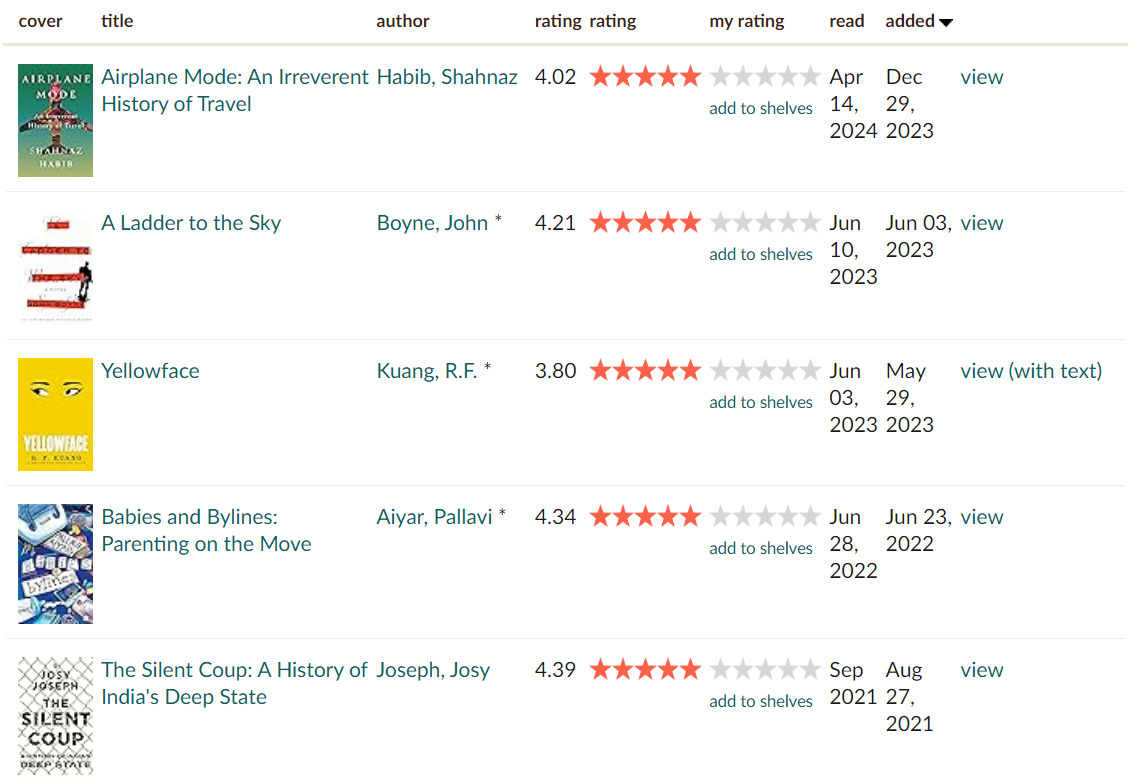

Определим функцию `create_interactions_subdataset`, при помощи которой будут формироваться и форматироваться части основного датасета взаимодействий пользователя с книгами:

In [ ]:
def create_interactions_subdataset(json_filename, csv_filename, start_index, finish_index):
    interactions = read_json(
        filename=json_filename,
        nrows=finish_index-start_index,
        skiprows=start_index
    )
    interactions = interactions.drop(
        columns=['review_text_incomplete', 'date_added', 'date_updated',
                 'read_at', 'started_at'])
    interactions.to_csv(csv_filename)

Приведём пример элемента датасета:

In [ ]:
interactions = read_json(
    filename='/content/drive/MyDrive/ВКР/children/goodreads_interactions_children.json.gz',
    nrows=100
)

In [ ]:
interactions.iloc[1]

user_id                   8842281e1d1347389f2ab93d60773d4d
book_id                                           33282947
review_id                 f171a68daa8092d8aea3dccc2e025a81
is_read                                              False
rating                                                   0
review_text_incomplete                                    
date_added                  Fri Feb 10 10:47:53 -0800 2017
date_updated                Fri Feb 10 10:48:21 -0800 2017
read_at                                                   
started_at                                                
Name: 1, dtype: object

Перейдём к непосредственно загрузке датасета. Воспользуемся набором данных о книгах жанра «Mystery, Thriller & Crime», в котором содержится информация о 24 799 896 пользовательских взаимодействий.

In [ ]:
%%time

create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_1.csv',
    start_index=0,
    finish_index=2_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_2.csv',
    start_index=2_000_001,
    finish_index=4_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_3.csv',
    start_index=4_000_001,
    finish_index=6_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_4.csv',
    start_index=6_000_001,
    finish_index=8_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_5.csv',
    start_index=8_000_001,
    finish_index=10_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_6.csv',
    start_index=10_000_001,
    finish_index=12_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_7.csv',
    start_index=12_000_001,
    finish_index=14_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_8.csv',
    start_index=14_000_001,
    finish_index=16_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_9.csv',
    start_index=16_000_001,
    finish_index=18_000_000
)
create_interactions_subdataset(
    json_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_mystery_thriller_crime.json',
    csv_filename='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_10.csv',
    start_index=18_000_001,
    finish_index=20_000_000
)

CPU times: user 10min 3s, sys: 1min 25s, total: 11min 28s
Wall time: 13min 18s


После сформируем финальный датасет с данными о взаимодействиях, конкатенировав полученные части наборов данных:

In [ ]:
interactions_1 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_1.csv'
)
interactions_2 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_2.csv'
)
interactions_3 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_3.csv'
)
interactions_4 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_4.csv'
)
interactions_5 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_5.csv'
)
interactions_6 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_6.csv'
)
interactions_7 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_7.csv'
)
interactions_8 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_8.csv'
)
interactions_9 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_9.csv'
)
interactions_10 = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions_10.csv'
)
interactions = pd.concat([interactions_1, interactions_2, interactions_3,
                          interactions_4, interactions_5, interactions_6,
                          interactions_7, interactions_8, interactions_9,
                          interactions_10])
interactions.to_csv('/content/drive/MyDrive/graduate_work/1. Input preprocessing/goodreads/goodreads_interactions.csv')


В результате получим датасет следующей структуры:

In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999991 entries, 0 to 1999998
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   book_id     int64 
 3   review_id   object
 4   is_read     bool  
 5   rating      int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 934.6+ MB


In [ ]:
interactions.head()

,Unnamed: 0,user_id,book_id,review_id,is_read,rating
0,0,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,True,3
1,1,8842281e1d1347389f2ab93d60773d4d,2279538,556e9e3f00fb5b7e4eaa116764b771b0,False,0
2,2,8842281e1d1347389f2ab93d60773d4d,20821043,4b15f8a08f04a17f9a47f2b76fec21e5,False,0
3,3,8842281e1d1347389f2ab93d60773d4d,31184479,0b9fc382ad38c5804ec46df84d66be6e,False,0
4,4,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,True,3


## 3) Формирование корпуса книжных аннотаций

Необходимо произвести препроцессирование книжных аннотаций – форматирование текстовых данных, которое повысит эффективность работы модели Doc2Vec. Для этого воспользуемся функцией `preprocess_documents()` библиотеки Gensim, которая позволяет произвести предварительную обработку «сырого» текста (удаление знаков препинания, множественных знаков пробела, предлогов, сведение всех символов к нижнему регистру и т. д.), для обработки данных датасета `book.csv`:

In [ ]:
%%time

books = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/children/books.csv',
    index_col='book_id'
).drop(columns=['title'])
df_corpus_annotations = books.rename(columns={'description': 'annotation'})
df_corpus_annotations['annotation'] = df_corpus_annotations['annotation'].astype(str)
df_corpus_annotations['annotation'] = preprocess_documents(df_corpus_annotations['annotation'])
df_corpus_annotations['annotation'] = df_corpus_annotations['annotation'].apply(lambda x: ' '.join(x))
df_corpus_annotations.to_csv('/content/drive/MyDrive/ВКР/children/children_corpus_annotations.csv')

CPU times: user 59.9 s, sys: 917 ms, total: 1min
Wall time: 1min 4s


В результате был получен следующий корпус:

In [ ]:
df_corpus_annotations

,annotation
book_id,
287141,relat vigor prose tale aenea legendari ancesto...
6066812,kara astonish discov portal open bedroom close...
89378,newberi medalist cynthia rylant classic bestse...
1698376,hen lai egg cow give milk eleph squirt water b...
2592648,ben draw train take sort wonder place return bed
...,...
823094,rhyme text illustr comic cat present numer exa...
13057172,hilari move novel david walliam number bestsel...
7925060,perfect remind lookout magic wonder need thing...


## 4) Формирование датасета пользовательских предпочтений

Далее требуется извлечь данные о пользовательских предпочтениях из информации о взаимодействиях пользователей с книгами. С этой целью сформируем датасет, в котором для каждого пользователя будут храниться идентификаторы книг, разделённые на различные категории в зависимости от вида взаимодействия пользователя с книгой.

In [ ]:
interactions = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/children/interactions.csv'
).drop(columns=['Unnamed: 0'])

interactions.head()

,user_id,book_id,review_id,is_read,rating
0,8842281e1d1347389f2ab93d60773d4d,10893214,5d0e4e8825c68740703f65a18813fc93,False,0
1,8842281e1d1347389f2ab93d60773d4d,33282947,f171a68daa8092d8aea3dccc2e025a81,False,0
2,8842281e1d1347389f2ab93d60773d4d,11387515,2fd3cd1acb30b099c135e358669639da,False,0
3,8842281e1d1347389f2ab93d60773d4d,24396144,d210e41fcc7e6dcd6ae896844a38a024,False,0
4,8842281e1d1347389f2ab93d60773d4d,20484662,a99f9fa4ec4fd94cc2419c78af2086a8,False,0


Датасет `interactions.csv` содержит информацию о 542 144 уникальных пользователей. В процессе создания набора данных, который будет использоваться для обучения моделей, ввиду временных ограничений были обработаны данные 100 000 пользователей и сохранены в датасет `user_data.csv`:

In [ ]:
user_ids = interactions['user_id'].unique()

In [ ]:
user_ids.size

542144

Определим категории взаимодействий:
-	`read` – пользователь прочитал книгу, находящуюся на его полке;
-	`shelved` – пользователь добавил книгу на полку, но не прочитал;
-	`rating_0` – пользователь поставил книге оценку «0»;
-	`rating_1` – пользователь поставил книге оценку «1»;
-	`rating_2` – пользователь поставил книге оценку «2»;
-	`rating_3` – пользователь поставил книге оценку «3»;
-	`rating_4` – пользователь поставил книге оценку «4»;
-	`rating_5` – пользователь поставил книге оценку «5»;

Таким образом для каждого пользователя будет собрана информация о его взаимодействиях с книгами. Взаимодействия будут разбиты на вышеопределённые категории и будут представлять из себя набор книжных идентификаторов.

Далее был определён следующий алгоритм сбора информации:

In [ ]:
%%time

dict_user_data = {'user_id': [], 'read': [], 'shelved': [],
                  'rating_0': [], 'rating_1': [], 'rating_2': [],
                  'rating_3': [], 'rating_4': [], 'rating_5': []}

users_amount = 0
gap = 0
for user_id in user_ids:
    gap += 1
    if (gap < 120000):
        continue

    current_user_data = interactions[interactions['user_id'] == user_id]
    dict_user_data['user_id'].append(user_id)
    current_read = current_user_data[current_user_data['is_read'] == True]['book_id'].values
    dict_user_data['read'].append(current_read)
    current_shelved = current_user_data[current_user_data['is_read'] == False]['book_id'].values
    dict_user_data['shelved'].append(current_shelved)
    current_rating_0 = current_user_data[(current_user_data['is_read'] == True) & (current_user_data['rating'] == 0)]['book_id'].values
    dict_user_data['rating_0'].append(current_rating_0)
    current_rating_1 = current_user_data[(current_user_data['is_read'] == True) & (current_user_data['rating'] == 1)]['book_id'].values
    dict_user_data['rating_1'].append(current_rating_1)
    current_rating_2 = current_user_data[(current_user_data['is_read'] == True) & (current_user_data['rating'] == 2)]['book_id'].values
    dict_user_data['rating_2'].append(current_rating_2)
    current_rating_3 = current_user_data[(current_user_data['is_read'] == True) & (current_user_data['rating'] == 3)]['book_id'].values
    dict_user_data['rating_3'].append(current_rating_3)
    current_rating_4 = current_user_data[(current_user_data['is_read'] == True) & (current_user_data['rating'] == 4)]['book_id'].values
    dict_user_data['rating_4'].append(current_rating_4)
    current_rating_5 = current_user_data[(current_user_data['is_read'] == True) & (current_user_data['rating'] == 5)]['book_id'].values
    dict_user_data['rating_5'].append(current_rating_5)

    users_amount += 1
    if (users_amount % 500 == 0):
        df_user_data = pd.DataFrame(dict_user_data)
        df_user_data.to_csv('/content/drive/MyDrive/ВКР/children/children_user_data_6.csv')
    if (users_amount == 30_000):
        break

В результате был получен набор пользовательских данных `children_user_data.csv`. Приведём его фрагмент:

In [ ]:
df_user_data = pd.read_csv(
    '/content/drive/MyDrive/ВКР/children/children_user_data.csv',
    index_col='user_id'
)

df_user_data.head()

,read,shelved,rating_0,rating_1,rating_2,rating_3,rating_4,rating_5
user_id,,,,,,,,
8842281e1d1347389f2ab93d60773d4d,[23310161 18296097 817720 502362 1969280 ...,[10893214 33282947 11387515 24396144 20484662 ...,[],[],[],[],[23310161 1027760 130580 14366 235324],[18296097 817720 502362 1969280 17290220 ...
72fb0d0087d28c832f15776b0d936598,[ 5 3562 3008 78411 8127 2839 91...,[9673436],[],[],[],[30119],[ 37741 767680],[ 5 3562 3008 78411 8127 2839 91...
ab2923b738ea3082f5f3efcbbfacb218,[240007 370493 30119 5],[],[],[],[],[5],[240007 370493 30119],[]
d986f354a045ffb91234e4af4d1b12fd,[ 9252036 12924291 11737313],[24396876 8127 3304291 966757 38709 ...,[ 9252036 11737313],[],[],[],[12924291],[]
7504b2aee1ecb5b2872d3da381c6c91e,[23302416 3636],[],[],[],[],[],[3636],[23302416]
